In [40]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from pathlib import Path
from dotenv import load_dotenv

import os
import io
import imageio

from scipy import ndimage

from utils.yolo import get_teeth_ROI
from utils.edge import quick_get_roi, integral_intensity_projection

load_dotenv()
# matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline


In [41]:
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')

data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'

image_number = 1
image_names = list(data_dir.glob('00008026.jpg'))
image_name = image_names[0]


D:\Users\douli\anaconda3\envs\dentist-CV-main\lib\site-packages\yolov5\utils\plots.py:475: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyxy = torch.tensor(xyxy).view(-1, 4)


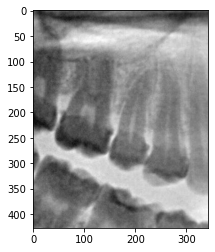

In [42]:
im_g, flag, tooth_position = quick_get_roi(image_name, model, roi_index=0)

plt.imshow(1 - im_g, cmap='gray')
plt.show()


In [43]:
source = im_g
if flag == 'upper':
    source = np.flip(source)

padding = 150
source = source[:-padding]
source = np.pad(source, (100, 100), mode='constant', constant_values=255)
minimum_value = np.Inf
target_angle = 0
result_hor = []

if tooth_position == 'left':
    angle_range = range(0, 21)
elif tooth_position == 'right':
    angle_range = range(-20, 1)
else:
    angle_range = range(0, 0)

with imageio.get_writer('rotation.gif', mode='I') as writer:
    for i in angle_range:
        source_r = ndimage.rotate(source, i, reshape=False, cval=255)
        hor, _ = integral_intensity_projection(source_r)

        # if flag == 'upper':
        #     hor_minimum = hor[100:].min()
        # elif flag == 'lower':
        hor_minimum = hor[:-100].min()
        # else:
        #     raise ValueError(f'flag only accept upper or lower but get {flag}.')

        if hor_minimum < minimum_value:
            target_angle = i
            minimum_value = hor_minimum
            result_hor = hor

        # Plot every step of rotation
        # fig, axs = plt.subplots(1, 2)
        # fig.suptitle(f'theta = {i}, value={minimum_value}')
        #
        # axs[0].imshow(1 - source_r, aspect='auto', cmap='gray')
        #
        # height, width = source_r.shape
        # index = np.array(range(height))
        # axs[1].plot(hor, index, 'g')
        # axs[1].xaxis.tick_top()
        #
        # axs[1].set_ylim(height, 0)

        # io_buf = io.BytesIO()
        # fig.savefig(io_buf, format='raw')
        # plt.show()

        # Build GIF
        # io_buf.seek(0)
        # img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
        #                      newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
        # writer.append_data(img_arr)
        #
        # io_buf.close()


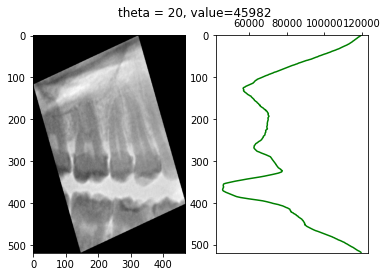

In [44]:
result = ndimage.rotate(im_g, target_angle, reshape=True, cval=255)
hor, _ = integral_intensity_projection(result)

# Plot every step of rotation
fig, axs = plt.subplots(1, 2)
fig.suptitle(f'theta = {target_angle}, value={hor.min()}')

axs[0].imshow(1 - result, aspect='auto', cmap='gray')

height, width = result.shape
index = np.array(range(height))
axs[1].plot(hor, index, 'g')
axs[1].xaxis.tick_top()

axs[1].set_ylim(height, 0)

plt.show()


In [45]:
print(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1)


288 432 -1
